# Import libraries

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

%matplotlib inline

# Import modules

In [2]:
# Add path for module
# FIXME: shouldn't need this with a package install (`__init__` should suffice?!)
MODEL_DIR = Path().resolve().parent / "YoungsEtAl2003"
sys.path.append(str(MODEL_DIR))

import run_displacement_model

# View the docstrings

In [3]:
help(run_displacement_model)

Help on module run_displacement_model:

NAME
    run_displacement_model

DESCRIPTION
    This file runs the YEA03 principal fault displacement model.
    - Any number of scenarios are allowed (e.g., user can enter multiple magnitudes).
    - The results are returned in a pandas DataFrame.
    - Results with full aleatory variability and with location-only aleatory variability are always returned.
    - The results with full aleatory variability are computed by convolving distributions for normalized
    displacement (based on magnitude) and normalization ratio (based on location) using the Monte Carlo sampling
    method described in Moss and Ross (2011).
    - Only the principal fault displacement models are implemented herein currently.
    - Only the D/AD relationship is implemented because the D/MD results on Figures 6 and 7a in Youngs
    et al. (2003) cannot be reproduced using the formulations and coefficients in the appendix.
    - The AD value used in YEA03 and herein is based

# An important note: Capturing aleatory variabilty in models that predict normalized displacement

The Youngs et al. (2003) model provides predictions based on normalized displacement $D/AD$ or $D/MD$ as a fuction of folded normalized location along the rupture. Accordingly, the aleatory variability associated with the position along the rupture is captured in the $D/AD$ and $D/MD$ formulations. Specifically, these models use Gamma and Beta distributions, respectively, to model the aleatory variability.

To obtain the actual displacement $D$, relations for the normalization variables $AD$ or $MD$ are required. Moss and Ross (2011) provide models for $AD$ and $MD$. The models are in the form of $\log_{10}(XD) \sim f(\mathbf{M})$, similar to the well-known Wells and Coppersmith (1994) models. The actual displacement is therefore calculated as $D = D/AD \times AD$, for example. 

However, simply multiplying the normalization ratio by the median-predicted $AD$ or $MD$ under-estimates the total aleatory variability because the variability in the magnitude scaling of $AD$ or $MD$ is not captured. As described in Youngs et al. (2003) and Moss and Ross (2011), the distribution for $D/AD$ (or $D/MD$) must be convolved with the distribution for $AD$ (or $MD$) to capture the full aleatory variability for both location dependence and magnitude dependence.

For completeness, the results with and without full aleatory variability are included in the outputs. The full aleatory variability is computed using Monte Carlo sampling, as described in Moss and Ross (2011). Five hundred thousand (500,000) samples are drawn for each distribution. (This value was selected because it generally produces smooth slip profiles but is still reasonably fast.) In general, neglecting the aleatory variability on magnitude will over-estimate  hazard at low percentiles (i.e., aleatory quantiles) and under-estimate hazard at high percentiles.

## Example

Let's look at the results for a simple case: a $\mathbf{M}$ 6.8 earthquake at $x/L$ position of 0.25. Let's use the $D/AD$ model formulation, and let's look at the 84th percentile prediction.

In [4]:
mag, loc, perc, model = (6.8, 0.25, 0.84, "d_ad")

results = run_displacement_model.run_model(
    magnitude=mag, location=loc, percentile=perc, submodel=model
)

results

,magnitude,location,style,percentile,model_name,mu,sigma,alpha,beta,xd,d_xd,displ_without_aleatory,displ_with_aleatory
0,6.8,0.25,normal,0.84,d_ad,-0.108,0.36,1.238623,0.895834,0.77983,1.969372,1.535775,2.077515


Note that in the above table, the `model_name` is specified in the row as "d_ad". This means that the value in column `xd` is "AD" or average displacement. Similarly, the value in `d_xd` corresponds to "D/AD".

As discussed abovery variability in the prediction. The predicted displacement (based on the magnitude, location, and percentile for a row) with full aleatory variability is in column `displ_with_aleatory`. The prediction with *only* location-based aleatory variability is in column `displ_without_aleatory`.

The full aleatory variability is computed by convolving 500,000 samples from the $AD$ distribution, which is based on $\mu$ and $\sigma$ in the table, with 500,000 samples from the $D/AD$ distribution, which is based on the $\alpha$ and $\beta$ values in the table. Then, the 84th percentile of the convolved distributions is calculated to provide the `displ_with_aleatory` value.

The `displ_without_aleatory` value represents the median-predicted $AD$, which is in column `xd`, and the 84th percentile $D/AD$, which is in column `d_xd`. In other words, it it is the value in `xd` multiplied by `d_xd`. 

In summary: 
- Each row contains results for the scenario (`magnitude`, `location`) and `model_name`. 
- Statistical distribution parameters `mu` and `sigma` are based on `magnitude` and the normalization variable provided in `model_name`.
- Statistical distribution parameters `alpha` and `beta` are based on `location` and the model in `model_name`.
- The `xd` value is the median prediction *Prob(50)* for the normalization variable. It is used in the final displacement calulation in column `displ_without_aleatory`.
- The `d_xd` value is the based on the aleatory quantile of interest, given in the `percentile` column. It is the prediction *Prob(percentile)* for the normalized ratio. It is used in the final displacement calulation in column `displ_without_aleatory`.
- The **recommended displacement with full aleatory variability** is provided in `displ_with_aleatory` and is based on the aleatory quantile of interest in the `percentile` column; specifically, it is the *Prob(percentile)* from 500,000 convolved distribution samples.

# Run displacement model

## Single scenarios

A single scenario is defined as a magnitude/location/percentile/style. Here is an example (note all parameters must be passed as keyword arguments).

In [5]:
mag, loc, perc, model = (6.8, 0.25, 0.5, "d_ad")

results = run_displacement_model.run_model(
    magnitude=mag, location=loc, percentile=perc, submodel=model
)

results

,magnitude,location,style,percentile,model_name,mu,sigma,alpha,beta,xd,d_xd,displ_without_aleatory,displ_with_aleatory
0,6.8,0.25,normal,0.5,d_ad,-0.108,0.36,1.238623,0.895834,0.77983,0.829335,0.646741,0.608636


This model should only be used for normal faulting. That is the default style. A `UserWarning` will be issued and the user input will be over-ridden in the output table if another style is entered, such as `style="strike-slip"`:

In [6]:
results = run_displacement_model.run_model(
    magnitude=mag, location=loc, percentile=perc, submodel=model, style="strike-slip"
)

results

D:\Documents\_mydocs\Work FDHI\TEAM\Journal\kea23\YoungsEtAl2003\run_displacement_model.py:468: UserWarning: This model is only recommended for normal faulting, but 'strike-slip' was entered.User input will be over-ridden.
  warnings.warn(


,magnitude,location,style,percentile,model_name,mu,sigma,alpha,beta,xd,d_xd,displ_without_aleatory,displ_with_aleatory
0,6.8,0.25,normal,0.5,d_ad,-0.108,0.36,1.238623,0.895834,0.77983,0.829335,0.646741,0.608636


Youngs et al. (2003) model provides three alternative submodels: one is based on normalized displacement $D/AD$ and the other two are on $D/MD$. 

The results for the $D/MD$ models on Figures 6 and 7a in Youngs et al. (2003) cannot be reproduced using the formulations and coefficient provided in their appendix; therefore, only the $D/AD$ model is implemented herein and that is the default for `submodel`. A `UserWarning` will be issued and the user input will be over-ridden in the output table if another `submodel` is entered:

In [7]:
results = run_displacement_model.run_model(
    magnitude=mag, location=loc, percentile=perc, submodel="d_md"
)

results

D:\Documents\_mydocs\Work FDHI\TEAM\Journal\kea23\YoungsEtAl2003\run_displacement_model.py:477: UserWarning: Only the D/AD relationship is implemented because the D/MD results on Figures 6 and 7a in Youngs et al. (2003) cannot be reproduced using the formulations and coefficients in the appendix.User input 'd_md' will be over-ridden.
  warnings.warn(


,magnitude,location,style,percentile,model_name,mu,sigma,alpha,beta,xd,d_xd,displ_without_aleatory,displ_with_aleatory
0,6.8,0.25,normal,0.5,d_ad,-0.108,0.36,1.238623,0.895834,0.77983,0.829335,0.646741,0.608636


An error results if the wrong submodel is entered:

In [8]:
del mag, loc, perc, model

## Multiple scenarios

Multiple magnitude/location/percentile/submodel scenarios can be run. All combinations of magnitudes, locations, percentiles, and submodels are run. Here is an example.

In [9]:
mags, locs, percs, models = (
    6.8,
    [0.25, 0.5],
    [0.5, 0.84],
    "d_ad",
)

results = run_displacement_model.run_model(
    magnitude=mags, location=locs, percentile=percs, submodel=models
)

results

,magnitude,location,style,percentile,model_name,mu,sigma,alpha,beta,xd,d_xd,displ_without_aleatory,displ_with_aleatory
0,6.8,0.25,normal,0.50,d_ad,-0.108,0.36,1.238623,0.895834,0.77983,0.829335,0.646741,0.608636
1,6.8,0.25,normal,0.84,d_ad,-0.108,0.36,1.238623,0.895834,0.77983,1.969372,1.535775,2.077515
2,6.8,0.50,normal,0.50,d_ad,-0.108,0.36,1.860788,0.795329,0.77983,1.224923,0.955232,0.909339
3,6.8,0.50,normal,0.84,d_ad,-0.108,0.36,1.860788,0.795329,0.77983,2.461902,1.919865,2.740790


In [10]:
del mags, locs, percs, models

# Scratch

In [11]:
mag = 6.75
locs = np.arange(0, 1.01, 0.01)
perc = [0.05, 0.15, 0.5, 0.85, 0.95]
models = "d_ad"

df = run_displacement_model.run_model(
    magnitude=mag, location=locs, percentile=perc, submodel=models
)

df.head()

,magnitude,location,style,percentile,model_name,mu,sigma,alpha,beta,xd,d_xd,displ_without_aleatory,displ_with_aleatory
0,6.75,0.0,normal,0.05,d_ad,-0.1425,0.36,0.824482,1.009041,0.720278,0.025012,0.018015,0.013691
1,6.75,0.0,normal,0.15,d_ad,-0.1425,0.36,0.824482,1.009041,0.720278,0.098627,0.071039,0.055965
2,6.75,0.0,normal,0.50,d_ad,-0.1425,0.36,0.824482,1.009041,0.720278,0.529333,0.381267,0.354922
3,6.75,0.0,normal,0.85,d_ad,-0.1425,0.36,0.824482,1.009041,0.720278,1.625788,1.171019,1.526587
4,6.75,0.0,normal,0.95,d_ad,-0.1425,0.36,0.824482,1.009041,0.720278,2.669693,1.922921,3.234006


Text(0.5, 1.02, 'Magnitude 6.75')

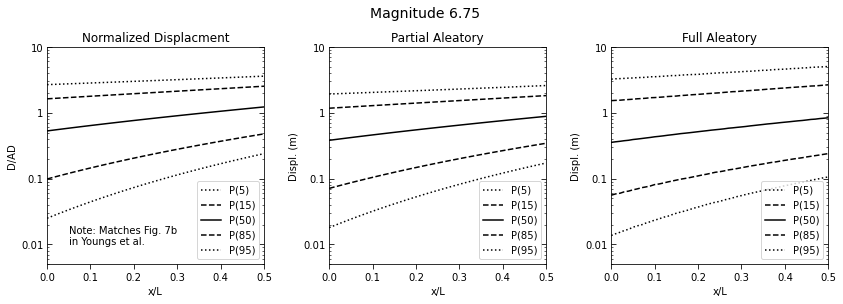

In [12]:
lines = {0.05: ":", 0.95: ":", 0.15: "--", 0.85: "--", 0.5: "-"}

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True)

for p, group in df.groupby(["percentile"]):
    group = group.sort_values(by="location")
    ptile = "Mean" if p == -1 else f"P({int(p*100)})"
    axs[0].semilogy(group["location"], group["d_xd"], c="k", ls=lines[p], label=ptile)
    axs[1].semilogy(
        group["location"],
        group["displ_without_aleatory"],
        c="k",
        ls=lines[p],
        label=ptile,
    )
    axs[2].semilogy(
        group["location"], group["displ_with_aleatory"], c="k", ls=lines[p], label=ptile
    )

for _ax in axs:
    _ax.set(xlabel="x/L", xlim=[0, 0.5], ylim=[0.005, 10])
    _ax.legend(loc="lower right")
    _ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    _ax.tick_params(
        axis="y", which="both", right=True, labelright=False, direction="in"
    )
    _ax.tick_params(axis='both', which='major', length=5)

axs[0].set(ylabel="D/AD", title="Normalized Displacment")
axs[1].set(ylabel="Displ. (m)", title="Partial Aleatory")
axs[2].set(ylabel="Displ. (m)", title="Full Aleatory")

axs[0].text(0.05, 0.01, "Note: Matches Fig. 7b\nin Youngs et al.")

fig.subplots_adjust(hspace=0.2, wspace=0.3)

fig.suptitle(f"Magnitude {mag}", y=1.02, fontsize=14)